### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os
import numpy as np
import pulp
import pickle
import seaborn as sns
import time
import pandas as pd

from masserstein import Spectrum, estimate_proportions
from matplotlib import pyplot as plt
from textwrap import wrap

### Loading the data

In [4]:
official_names = ['Isopropyl_myristate', 'Benzyl_benzoate', 'Alpha_pinene', 'Limonene', 
                  'Benzyl alcohol', 'Benzyl salicylate', 'Etanol', 'Eugenol', 'Geraniol', 'Menthone']

In [5]:
components_present = np.loadtxt(os.getcwd()+'/Mieszanina_perfumy.csv', skiprows=1, usecols=range(7), 
                      delimiter=',',dtype=float)

In [6]:
ppm_components_present = components_present[:,0]

In [7]:
components_present = components_present[:,[1,2,4,5]] #no menton

In [8]:
components_absent = np.loadtxt(os.getcwd()+'/other_ingredients_corr.csv', skiprows=1, 
                      delimiter=',',dtype=float)

In [9]:
ppm_components_absent = components_absent[:,0]

In [10]:
components_absent = components_absent[:,1:]

In [11]:
mix = np.loadtxt(os.getcwd()+'/Mieszanina_perfumy_bez_menthonu.csv', skiprows=1, usecols=range(2), 
                  delimiter=',',dtype=float)

In [12]:
ppm = mix[:,0]

In [13]:
mix = mix[:,1]

In [14]:
#From email: 2.2449, 0.3269, 0.2533, 0.2651
r_sum = 2.2449 + 0.3269 + 0.2533 + 0.2651
real_proportions = [2.2449/r_sum, 0.3269/r_sum, 0.2533/r_sum, 0.2651/r_sum]
print('Real proportions:')
real_proportions

Real proportions:


[0.7264578344443725,
 0.10578603326645526,
 0.081968804608116,
 0.08578732768105625]

In [15]:
proportions_rescaled = [real_proportions[0]*34, real_proportions[1]*12,
                        real_proportions[2]*16, real_proportions[3]*16]
vis_prop = [x/sum(proportions_rescaled) for x in proportions_rescaled]
print('Proportions that should be visible in mixture computed based on number of H:')
vis_prop

Proportions that should be visible in mixture computed based on number of H:


[0.8620208303686988,
 0.04430349725220739,
 0.04577169717134345,
 0.04790397520775029]

In [16]:
real_visible_proportions = np.array(vis_prop)#np.array with shape (number of components,)

### Preprocessing

In [17]:
components_present_ints = []
names_present = []
for i in range(components_present.shape[1]):
    components_present_ints.append(components_present[:,i])
    names_present.append('comp'+str(i))

In [18]:
components_absent_ints = []
names_absent = []
for i in range(components_absent.shape[1]):
    components_absent_ints.append(components_absent[:,i])
    names_absent.append('comp'+str(i))

### Additional preprocessing for this specific case

In [19]:
for i, ints in enumerate(components_present_ints):
    components_present_ints[i] = components_present_ints[i][np.logical_and(ppm_components_present>-5,
                                                                           ppm_components_present<15)]
ppm_components_present= ppm_components_present[np.logical_and(ppm_components_present>-5, ppm_components_present<15)]

In [20]:
for i, ints in enumerate(components_absent_ints):
    components_absent_ints[i] = components_absent_ints[i][np.logical_and(ppm_components_absent>-5,
                                                                           ppm_components_absent<15)]
ppm_components_absent= ppm_components_absent[np.logical_and(ppm_components_absent>-5, ppm_components_absent<15)]

In [21]:
mix = mix[np.logical_and(ppm>-5, ppm<15)]

In [22]:
ppm = ppm[np.logical_and(ppm>-5, ppm<15)]

### Shifting one spectrum (limonene) to the right in order to align

NOTE: Run either cell below or the next after the cell below, depending if you want to include the shift in ppm or not.

In [23]:
# #version 15.10.2022.: NO SHIFT IN PPM FOR ANY SPECTRUM
# spectra_present = []
# for i, comp_ints in enumerate(components_present_ints):
# #     if not i==3:
# #         spectra_present.append(Spectrum(confs=list(zip(ppm_components_present, comp_ints))))
# #     else:
# #         spectra_present.append(Spectrum(confs=list(zip(ppm_components_present+0.1, comp_ints))))
#     spectra_present.append(Spectrum(confs=list(zip(ppm_components_present, comp_ints))))

In [24]:
#version 16.10.2022.: WITH SHIFT IN PPM
spectra_present = []
for i, comp_ints in enumerate(components_present_ints):
    if not i==3:
        spectra_present.append(Spectrum(confs=list(zip(ppm_components_present, comp_ints))))
    else:
        spectra_present.append(Spectrum(confs=list(zip(ppm_components_present+0.1, comp_ints))))
    #spectra_present.append(Spectrum(confs=list(zip(ppm_components_present, comp_ints))))

In [25]:
spectra_absent = []
for comp_ints in components_absent_ints:
    spectra_absent.append(Spectrum(confs=list(zip(ppm_components_absent, comp_ints))))

In [26]:
mix = Spectrum(confs=list(zip(ppm,mix)))

In [27]:
#spectra_absent[5].plot(profile=True)

### Additional preprocessing: common mass axis for absent and present components

In [28]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [29]:
present_and_absent_cma = common_mass_axis(spectra_present + spectra_absent)

In [30]:
preprocessed_spectra = []
for sp in (spectra_present + spectra_absent):
    preprocessed_spectra.append(sp.resample(present_and_absent_cma))

In [31]:
#spectra_present[3].plot(profile=True)

In [32]:
ints = []
for sp in preprocessed_spectra:
    ints.append(np.array(sp.confs)[:,1])

In [33]:
components = np.concatenate([ints], axis=1).T

In [34]:
ppm_components = present_and_absent_cma

In [35]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [36]:
spectra = []
for comp_ints in components_ints:
    spectra.append(Spectrum(confs=list(zip(ppm_components, comp_ints))))

In [37]:
# mix.plot(profile=True)
# spectra[3].plot(profile=True)

### Preprocessing

In [38]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [39]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [40]:
spectra_and_mixture = spectra + [mix]

In [41]:
cma = common_mass_axis(spectra_and_mixture)

In [42]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [43]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [44]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [45]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [46]:
spectra_and_mixture = spectra + [mix]

In [47]:
spectra_and_mixture = shift(spectra_and_mixture)

In [48]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [49]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [50]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [51]:
components_ints = []
components_ppm = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))
    components_ppm.append(np.array(spectrum.confs)[:,0])

In [52]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

<IPython.core.display.Javascript object>


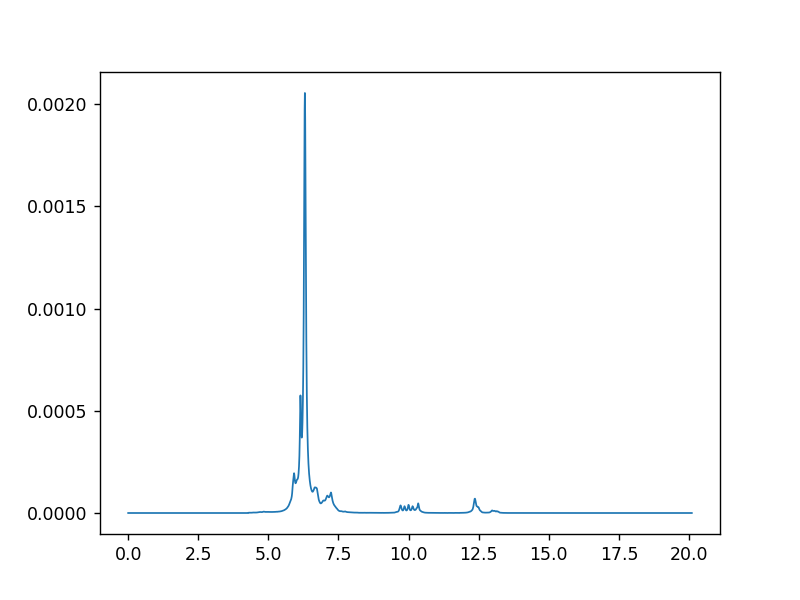

In [53]:
mix.plot(profile=True)
# comp0.plot(profile=True)
# comp1.plot(profile=True) 
# comp2.plot(profile=True)
# comp3.plot(profile=True) 
# comp4.plot(profile=True)
# comp5.plot(profile=True) 
# comp6.plot(profile=True)
# comp7.plot(profile=True) 
# comp8.plot(profile=True) 

### Cutting useless data points

In [54]:
for i, ints in enumerate(components_ints):
    components_ints[i] = components_ints[i][np.logical_and(components_ppm[i]>5, components_ppm[i]<16)]
    components_ppm[i] = components_ppm[i][np.logical_and(components_ppm[i]>5, components_ppm[i]<16)]

In [55]:
mix_ints = mix_ints[np.logical_and(ppm>5, ppm<16)]
ppm = ppm[np.logical_and(ppm>5, ppm<16)]

In [56]:
spectra = []
for i, comp_ints in enumerate(components_ints):
    spectra.append(Spectrum(confs=list(zip(components_ppm[i], comp_ints))))

In [57]:
mix = Spectrum(confs=list(zip(ppm, mix_ints)))

In [58]:
spectra_and_mixture = spectra + [mix]

In [59]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [60]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [61]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [62]:
cma = common_mass_axis(spectra_and_mixture)

In [63]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [64]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [65]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [66]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [67]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

<IPython.core.display.Javascript object>


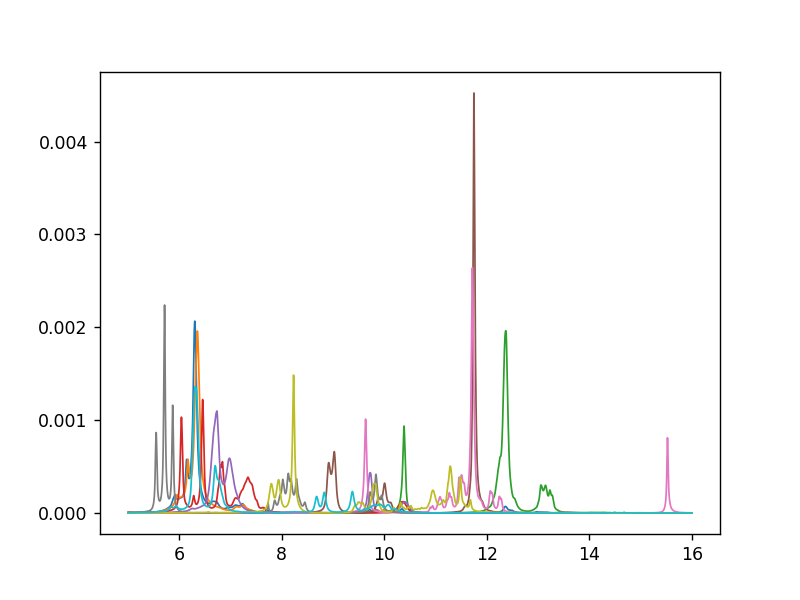

In [68]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 
comp2.plot(profile=True)
comp3.plot(profile=True) 
comp4.plot(profile=True)
comp5.plot(profile=True) 
comp6.plot(profile=True)
comp7.plot(profile=True) 
comp8.plot(profile=True) 

### Finding best kappa for simple library

In [83]:
import time
import pandas as pd
import pulp

In [84]:
lower_limit = 0.1
upper_limit = 1.1
step = 0.1

In [95]:
list_of_estimation_results = []
for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
    fixed_kappa = []
    for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
        start = time.time()
        estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3], 
                                   MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI())
        end = time.time()
        fixed_kappa.append(estimation['proportions'])
        print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
        print('It took: '+str(end-start)+' seconds.')
        print(estimation['proportions'])
    list_of_estimation_results.append(fixed_kappa)

Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3398956.87it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xe57c20e3
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.70s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.11s/it]


Gurobi status= 2
Estimation for 0.1 and 0.1 done
It took: 11.15038275718689 seconds.
[0.8886339270649978, 0.03298810458099992, 0.0, 0.04323968886199989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 207126.12it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3457490.51it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x64bd2259
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 2e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.77s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.71s/it]


Gurobi status= 2
Estimation for 0.1 and 0.2 done
It took: 11.746322631835938 seconds.
[0.8461390490209979, 0.031375997106999926, 0.0060181691149999855, 0.04776964284599988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3197935.58it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x0296f994
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 3e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.73s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:12<00:00, 12.20s/it]


Gurobi status= 2
Estimation for 0.1 and 0.30000000000000004 done
It took: 12.233757019042969 seconds.
[0.8412851580329979, 0.030770142836999925, 0.007646229560999981, 0.04553461881099989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3376997.18it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x39b8e167
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 4e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.73s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.63s/it]


Gurobi status= 2
Estimation for 0.1 and 0.4 done
It took: 11.66533875465393 seconds.
[0.8416882089509979, 0.030527444763999927, 0.0070175851919999825, 0.045605612488999886]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 80273.76it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3444657.35it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x922673d2
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 5e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.72s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:12<00:00, 12.16s/it]


Gurobi status= 2
Estimation for 0.1 and 0.5 done
It took: 12.198020935058594 seconds.
[0.8419250024189979, 0.030380363395999928, 0.006609207835999983, 0.04566760299699989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3543708.86it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x444f7240
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 6e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.76s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.42s/it]


Gurobi status= 2
Estimation for 0.1 and 0.6 done
It took: 11.459835052490234 seconds.
[0.8411886371139979, 0.030267111926999928, 0.006293690089999984, 0.04587739524299989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 102927.71it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3263808.51it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xa7dde459
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 7e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.85s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.93s/it]


Gurobi status= 2
Estimation for 0.1 and 0.7000000000000001 done
It took: 11.972319602966309 seconds.
[0.8410707800589979, 0.030191941712999926, 0.006033973222999985, 0.04593439394199989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 140985.01it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3252370.47it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x55182275
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.77s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.52s/it]


Gurobi status= 2
Estimation for 0.1 and 0.8 done
It took: 11.559627532958984 seconds.
[0.8410948840779979, 0.030103899927999927, 0.0060316856339999855, 0.04593646331399989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3281472.36it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xf2537885
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.84s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.64s/it]


Gurobi status= 2
Estimation for 0.1 and 0.9 done
It took: 11.676601648330688 seconds.
[0.8411062848279979, 0.03005841766099993, 0.0060303126879999855, 0.04593752895399989]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2882977.40it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xd46b43a4
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.45s/it]


Gurobi status= 2
Estimation for 0.1 and 1.0 done
It took: 11.486344814300537 seconds.
[0.8411190158039978, 0.029994129729999926, 0.006030469464999986, 0.04593822605699989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3360402.29it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x36df233f
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 2e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.95s/it]


Estimation for 0.2 and 0.1 done
It took: 10.991112232208252 seconds.
[0.9165856830069978, 0.03715699245299991, 0.0, 0.0387802073339999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3369740.20it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xd29457d5
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 2e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.72s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.11s/it]


Gurobi status= 2
Estimation for 0.2 and 0.2 done
It took: 11.14468264579773 seconds.
[0.8756159294579979, 0.03741540372099991, 0.01753781101299996, 0.04618807281699989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3334284.85it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x94697554
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 3e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.73s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.22s/it]


Estimation for 0.2 and 0.30000000000000004 done
It took: 11.26124358177185 seconds.
[0.8678180763969979, 0.03724728592499991, 0.02347981404699994, 0.0430485056369999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3365127.02it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x32d5241d
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 4e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.46s/it]


Gurobi status= 2
Estimation for 0.2 and 0.4 done
It took: 11.494577169418335 seconds.
[0.8682405874639979, 0.03690973347799991, 0.022603707944999944, 0.0432157732739999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3284672.18it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x729948eb
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 5e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.74s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.31s/it]


Gurobi status= 2
Estimation for 0.2 and 0.5 done
It took: 11.347956418991089 seconds.
[0.8686734882169979, 0.03672463067699991, 0.02185618102799995, 0.0434444591249999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3284316.33it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xcf5c69d1
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 6e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.73s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.11s/it]


Gurobi status= 2
Estimation for 0.2 and 0.6 done
It took: 11.153035163879395 seconds.
[0.8690866391699978, 0.03663109789099991, 0.021187230173999948, 0.0435726005959999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88768.34it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2737787.11it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x7e69e3c4
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 7e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.68s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.29s/it]


Gurobi status= 2
Estimation for 0.2 and 0.7000000000000001 done
It took: 11.33593463897705 seconds.
[0.8692689916569979, 0.03656848520799991, 0.020743444177999948, 0.043659539631999894]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3364255.68it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xf8819f5d
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.84s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.46s/it]


Gurobi status= 2
Estimation for 0.2 and 0.8 done
It took: 11.498629093170166 seconds.
[0.8693011349559979, 0.03644785424399991, 0.02031854016499995, 0.0436901722429999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3319195.94it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x5882d730
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.84s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.09s/it]


Estimation for 0.2 and 0.9 done
It took: 11.131298065185547 seconds.
[0.8693708006849978, 0.03639140580999991, 0.02017320609799995, 0.043764425130999894]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3292162.74it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xc17d6cbd
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.82s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.16s/it]


Gurobi status= 2
Estimation for 0.2 and 1.0 done
It took: 11.200931072235107 seconds.
[0.8694020832579978, 0.03634233138699991, 0.020173982004999952, 0.043766000222999896]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2907957.79it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x29e766c9
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 3e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.76s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.16s/it]


Estimation for 0.30000000000000004 and 0.1 done
It took: 11.205749034881592 seconds.
[0.9238476482409977, 0.03767224400199991, 0.0, 0.03585336222599991]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2808376.96it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x3305c69e
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 3e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.74s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.15s/it]


Estimation for 0.30000000000000004 and 0.2 done
It took: 11.186052322387695 seconds.
[0.8789358822639979, 0.0386667592839999, 0.017919732986999955, 0.04662779878699989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3435029.95it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x3c55a7df
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 3e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.75s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.06s/it]


Estimation for 0.30000000000000004 and 0.30000000000000004 done
It took: 11.099115133285522 seconds.
[0.8680173052049979, 0.038790090827999904, 0.026519044678999935, 0.04498264759199989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3324534.41it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xf3793d50
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 4e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.74s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.43s/it]


Gurobi status= 2
Estimation for 0.30000000000000004 and 0.4 done
It took: 11.464204549789429 seconds.
[0.8685482901019979, 0.038501119741999906, 0.025893669240999936, 0.04520628557299989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3315928.54it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xd2761444
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 5e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.68s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.41s/it]


Gurobi status= 2
Estimation for 0.30000000000000004 and 0.5 done
It took: 11.447639465332031 seconds.
[0.8689590652899979, 0.038381538986999905, 0.025417360037999936, 0.04534425403799989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3332818.64it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x95bd3768
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 6e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.77s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.84s/it]


Gurobi status= 2
Estimation for 0.30000000000000004 and 0.6 done
It took: 10.875216484069824 seconds.
[0.8693698793739979, 0.03832598410799991, 0.02480291909399994, 0.04554645659299989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 207126.12it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3486784.54it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xea9248e2
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 7e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.68s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.46s/it]


Gurobi status= 2
Estimation for 0.30000000000000004 and 0.7000000000000001 done
It took: 11.493168354034424 seconds.
[0.8696273752579979, 0.03827192743399991, 0.024272393798999942, 0.04580765730399989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3470154.83it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x6fd86b1e
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.57s/it]


Estimation for 0.30000000000000004 and 0.8 done
It took: 11.60359501838684 seconds.
[0.8698650295379979, 0.03822691234899991, 0.02407168628899994, 0.04579577576699989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3113635.33it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xde047ff1
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.03s/it]


Estimation for 0.30000000000000004 and 0.9 done
It took: 11.064138174057007 seconds.
[0.8699632454939978, 0.03820263771199991, 0.023968155355999943, 0.04582615882899989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3292639.49it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x5ae10349
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.80s/it]


Estimation for 0.30000000000000004 and 1.0 done
It took: 10.842370986938477 seconds.
[0.8699978671769979, 0.03817248893299991, 0.02396896543699994, 0.04582837001999989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3496301.39it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x189d79fc
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 4e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.68s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.06s/it]


Estimation for 0.4 and 0.1 done
It took: 11.100436449050903 seconds.
[0.9273087525729978, 0.03771124323999991, 0.0, 0.03435098927299992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3081042.31it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xcbab163a
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 4e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.71s/it]


Estimation for 0.4 and 0.2 done
It took: 10.747352361679077 seconds.
[0.8911586096419978, 0.0386711752729999, 0.015449299250999962, 0.04540173325099989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3522162.80it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x52f7126a
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 4e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.68s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.85s/it]


Estimation for 0.4 and 0.30000000000000004 done
It took: 10.887234926223755 seconds.
[0.8799806560979979, 0.039272751265999904, 0.022938830444999943, 0.04599886586699989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3363011.68it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x01d73843
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 4e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.13s/it]


Estimation for 0.4 and 0.4 done
It took: 11.162648916244507 seconds.
[0.8794992661559979, 0.038995076346999905, 0.02372991548399994, 0.04529582664499989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 134217.73it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3366247.98it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xb2e67762
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 5e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.73s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.57s/it]


Gurobi status= 2
Estimation for 0.4 and 0.5 done
It took: 11.60674524307251 seconds.
[0.8797973250469979, 0.0388401350569999, 0.02344716241799994, 0.04542759392099989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 134217.73it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3262403.61it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x3cb32fae
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 6e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.73s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.87s/it]


Estimation for 0.4 and 0.6 done
It took: 10.907604694366455 seconds.
[0.8803185651519979, 0.0387851742019999, 0.022524229153999945, 0.04582838952299989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 128070.35it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3337711.03it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x214b9af7
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 7e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.71s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.66s/it]


Estimation for 0.4 and 0.7000000000000001 done
It took: 10.69742465019226 seconds.
[0.8804409687189979, 0.0387213234909999, 0.022109223075999943, 0.04594951622699989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3407233.65it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xd591f8ce
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.71s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.95s/it]


Estimation for 0.4 and 0.8 done
It took: 10.990746259689331 seconds.
[0.8807782934329978, 0.0386878312079999, 0.02172301968999995, 0.04605499067599989]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2814634.60it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x100c5e46
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.71s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.09s/it]


Estimation for 0.4 and 0.9 done
It took: 11.134016752243042 seconds.
[0.8809372146389979, 0.038638821632999906, 0.02162386453899995, 0.04606623053699989]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76608.29it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2888746.28it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xdfcdc359
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.71s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.27s/it]


Estimation for 0.4 and 1.0 done
It took: 11.307414770126343 seconds.
[0.8809498662009979, 0.0386320321199999, 0.02162422129599995, 0.04606689091899989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3438666.41it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x7600ecb1
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 5e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.75s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.74s/it]


Estimation for 0.5 and 0.1 done
It took: 10.778129816055298 seconds.
[0.9286279703609978, 0.03760057781699991, 0.0, 0.033771451821999914]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3397814.02it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x7243cbb6
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 5e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.73s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.62s/it]


Estimation for 0.5 and 0.2 done
It took: 10.65828537940979 seconds.
[0.8999622471339978, 0.0385729890349999, 0.013282936823999968, 0.04506563384399989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3360526.45it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x51dab40d
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 5e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.74s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.60s/it]


Estimation for 0.5 and 0.30000000000000004 done
It took: 10.639388084411621 seconds.
[0.8893695483519978, 0.0394135520479999, 0.019027087811999955, 0.04778184252999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 212369.82it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3419660.40it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x63f99c3a
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 5e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.82s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.45s/it]


Estimation for 0.5 and 0.4 done
It took: 11.491538047790527 seconds.
[0.8887962014199978, 0.0390501755319999, 0.02039135403599995, 0.046897316950999884]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3372864.38it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x238d0663
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 5e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.82s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.07s/it]


Estimation for 0.5 and 0.5 done
It took: 11.112387418746948 seconds.
[0.8891084861769978, 0.0388640692789999, 0.02016191997899995, 0.046976014691999884]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3348771.60it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xf354f391
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 6e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.74s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.34s/it]


Gurobi status= 2
Estimation for 0.5 and 0.6 done
It took: 11.380268096923828 seconds.
[0.8897770408109977, 0.0387876737519999, 0.01935659021299995, 0.04720970514399988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3288472.64it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x1627e755
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 7e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.74s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.69s/it]


Estimation for 0.5 and 0.7000000000000001 done
It took: 10.725489139556885 seconds.
[0.8902388056909978, 0.038750566987999904, 0.018664056787999955, 0.047527115572999885]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3342126.48it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xb1a0b322
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.71s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.99s/it]


Estimation for 0.5 and 0.8 done
It took: 11.024808406829834 seconds.
[0.8905379622879978, 0.0387212010889999, 0.018381773774999954, 0.04755712161899988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 207126.12it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3456439.32it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xbf5eaac0
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.74s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.94s/it]


Estimation for 0.5 and 0.9 done
It took: 10.97909426689148 seconds.
[0.8906557265749978, 0.0386714765259999, 0.018237944749999953, 0.04762717097099988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3485982.67it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x2233e4ec
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.68s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.44s/it]


Estimation for 0.5 and 1.0 done
It took: 11.48194432258606 seconds.
[0.8906588694629978, 0.038667243228999906, 0.018238151709999956, 0.047627303775999885]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 204600.20it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3454601.28it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xe61bbaf8
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 6e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.70s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.67s/it]


Estimation for 0.6 and 0.1 done
It took: 10.704740762710571 seconds.
[0.9286279703609978, 0.03760057781699991, 0.0, 0.033771451821999914]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3378502.52it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x31a62e97
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 6e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.72s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.43s/it]


Estimation for 0.6 and 0.2 done
It took: 10.470657587051392 seconds.
[0.9026853251069977, 0.038517525905999904, 0.01240843546599997, 0.04505309418299989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3502360.13it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x13ac96b4
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 6e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.68s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.88s/it]


Estimation for 0.6 and 0.30000000000000004 done
It took: 10.91203260421753 seconds.
[0.8925338320869978, 0.039398393798999905, 0.01684145406199996, 0.04909828828999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3316291.26it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x0b35a722
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 6e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.73s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.46s/it]


Estimation for 0.6 and 0.4 done
It took: 11.500190258026123 seconds.
[0.8915732004099978, 0.039119670553999904, 0.018381379250999953, 0.048432592447999884]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3444787.82it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x4a31269b
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 6e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.70s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.22s/it]


Estimation for 0.6 and 0.5 done
It took: 11.25344467163086 seconds.
[0.8919581449019978, 0.038888801136999905, 0.018068792495999957, 0.048595294798999884]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83468.74it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2933091.07it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x9f3f2195
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 6e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.71s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.93s/it]


Estimation for 0.6 and 0.6 done
It took: 10.966759443283081 seconds.
[0.8926209698499977, 0.038795854750999906, 0.017297699521999957, 0.04879570160299988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3325385.30it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x573f49f5
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 7e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.70s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.95s/it]


Estimation for 0.6 and 0.7000000000000001 done
It took: 10.98660397529602 seconds.
[0.8930659566759978, 0.0387611188129999, 0.016741190824999957, 0.04897986664299988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3408766.09it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x07723e7a
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.68s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.78s/it]


Estimation for 0.6 and 0.8 done
It took: 10.814960718154907 seconds.
[0.8934024056839978, 0.038724041653999904, 0.016286102918999963, 0.04917770491299988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3424166.56it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xdc86eb7c
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.67s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.06s/it]


Estimation for 0.6 and 0.9 done
It took: 11.093111753463745 seconds.
[0.8934879388319977, 0.0386874067929999, 0.01625820583599996, 0.049171874415999885]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88768.34it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2990474.07it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xe3c7f71c
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.13s/it]


Estimation for 0.6 and 1.0 done
It took: 11.166143655776978 seconds.
[0.8934895072469978, 0.0386849764659999, 0.01625825966099996, 0.049171951102999885]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 207126.12it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3340530.67it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x3d7a262b
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 7e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.68s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.78s/it]


Estimation for 0.7000000000000001 and 0.1 done
It took: 10.820187091827393 seconds.
[0.9286279703609978, 0.03760057781699991, 0.0, 0.033771451821999914]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3216256.03it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xf187f915
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 7e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.74s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.08s/it]


Estimation for 0.7000000000000001 and 0.2 done
It took: 11.122198820114136 seconds.
[0.9039794731099978, 0.038471061093999906, 0.011984987798999971, 0.04499597309999989]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2806383.85it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x15e225e8
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 7e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.70s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.83s/it]


Estimation for 0.7000000000000001 and 0.30000000000000004 done
It took: 10.867224216461182 seconds.
[0.8940186624279978, 0.0393807414199999, 0.015537925610999962, 0.04998260388599988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3374240.85it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xe8d79399
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 7e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.26s/it]


Estimation for 0.7000000000000001 and 0.4 done
It took: 11.29945969581604 seconds.
[0.8928874263689978, 0.039195884774999905, 0.016726348873999958, 0.049863763316999876]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3373865.34it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xd16dd8ad
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 7e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.77s/it]


Estimation for 0.7000000000000001 and 0.5 done
It took: 10.808297872543335 seconds.
[0.8933187977789978, 0.038924798878999904, 0.01645241892699996, 0.04996714729199987]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3447268.62it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x696f7a57
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 7e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.68s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.64s/it]


Estimation for 0.7000000000000001 and 0.6 done
It took: 10.672919750213623 seconds.
[0.8939885509869978, 0.038818255988999906, 0.015652896070999962, 0.050234855628999875]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3345568.80it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x083193a7
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 7e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.78s/it]


Estimation for 0.7000000000000001 and 0.7000000000000001 done
It took: 10.821338176727295 seconds.
[0.8944359186949978, 0.0387711378029999, 0.015126780549999963, 0.05039317134399988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3335140.74it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x46dd7694
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.78s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.92s/it]


Estimation for 0.7000000000000001 and 0.8 done
It took: 11.959412336349487 seconds.
[0.8947788315889977, 0.0387288502209999, 0.014773282176999964, 0.050489768565999876]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89717.73it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2836580.73it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x8a0180f7
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.83s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.32s/it]


Estimation for 0.7000000000000001 and 0.9 done
It took: 11.36060118675232 seconds.
[0.8948022657299978, 0.0387235717079999, 0.014773705481999964, 0.05049109084499988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3390214.63it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x7dea3306
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.72s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.42s/it]


Estimation for 0.7000000000000001 and 1.0 done
It took: 11.460363626480103 seconds.
[0.8948035655249977, 0.0387218003089999, 0.014773737512999964, 0.05049116417699988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 217885.92it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3448837.28it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xa5472713
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.70s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.25s/it]


Estimation for 0.8 and 0.1 done
It took: 11.288273572921753 seconds.
[0.9286279703609978, 0.03760057781699991, 0.0, 0.033771451821999914]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2338088.07it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xc8515072
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.74s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.61s/it]


Estimation for 0.8 and 0.2 done
It took: 10.653067827224731 seconds.
[0.9045843647019978, 0.038457070207999905, 0.01177909082399997, 0.044985347242999886]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3399973.38it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x0cd7cd9d
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.74s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.59s/it]


Estimation for 0.8 and 0.30000000000000004 done
It took: 10.624689817428589 seconds.
[0.8948438108289978, 0.0393870090709999, 0.014681156097999963, 0.050571220690999875]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3463019.76it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xb7e4eaab
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.75s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.94s/it]


Estimation for 0.8 and 0.4 done
It took: 10.972273349761963 seconds.
[0.8936573210339978, 0.039282077688999904, 0.015390872078999961, 0.050993721593999876]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3311823.17it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x534ebde0
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.38s/it]


Estimation for 0.8 and 0.5 done
It took: 11.413469552993774 seconds.
[0.8941109383479978, 0.0389699242269999, 0.015047489614999963, 0.05120589588199988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 147168.56it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3400990.50it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xe2ce34f8
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.70s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.70s/it]


Estimation for 0.8 and 0.6 done
It took: 10.739130020141602 seconds.
[0.8947592152829977, 0.0388397941479999, 0.014422369672999966, 0.051318333945999876]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 223696.21it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3510335.71it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x77aff153
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.90s/it]


Estimation for 0.8 and 0.7000000000000001 done
It took: 10.934035539627075 seconds.
[0.8952466785289978, 0.038785966310999904, 0.013917907229999965, 0.05143211910699987]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 133152.51it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3475193.46it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x27632f92
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 8e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.67s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.93s/it]


Estimation for 0.8 and 0.8 done
It took: 10.963804721832275 seconds.
[0.8954980608949977, 0.0387397786049999, 0.013708738848999967, 0.05149351695099987]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3513318.96it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x6c18d228
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.68s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.24s/it]


Estimation for 0.8 and 0.9 done
It took: 11.28472113609314 seconds.
[0.8955051731919977, 0.0387345885069999, 0.013708492442999968, 0.051494191107999875]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3331353.72it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xeb26c837
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.74s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.62s/it]


Estimation for 0.8 and 1.0 done
It took: 11.658277034759521 seconds.
[0.8955079967579977, 0.038732959425999906, 0.013704975079999968, 0.051496407756999873]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3426488.64it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x22d5fded
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.74s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.02s/it]


Estimation for 0.9 and 0.1 done
It took: 11.064674615859985 seconds.
[0.9286279703609978, 0.03760057781699991, 0.0, 0.033771451821999914]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 30012.91it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2721647.30it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x55831c76
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.82s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.86s/it]


Estimation for 0.9 and 0.2 done
It took: 10.902148008346558 seconds.
[0.9047915779769978, 0.038448357052999906, 0.01177670690799997, 0.044928648731999886]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 70789.94it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2883983.00it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x87703f35
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.84s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.86s/it]


Estimation for 0.9 and 0.30000000000000004 done
It took: 10.91240119934082 seconds.
[0.8953017572299978, 0.0394052773339999, 0.014173114829999965, 0.05088678144399988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3316775.02it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x5262968a
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.82s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.36s/it]


Estimation for 0.9 and 0.4 done
It took: 11.401373863220215 seconds.
[0.8940702966849978, 0.039308677136999905, 0.014640669325999963, 0.05163134388799988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3421461.44it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x22d1188b
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.82s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.38s/it]


Estimation for 0.9 and 0.5 done
It took: 11.418703317642212 seconds.
[0.8945323912199977, 0.038992590784999906, 0.014318687039999965, 0.051828269763999874]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3420174.79it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x4e206987
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.66s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.11s/it]


Estimation for 0.9 and 0.6 done
It took: 11.144508123397827 seconds.
[0.8952134658729978, 0.0388610884489999, 0.013511287628999967, 0.052125464394999876]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3410555.67it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x4fb878d7
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.46s/it]


Estimation for 0.9 and 0.7000000000000001 done
It took: 11.50570559501648 seconds.
[0.8956801160099978, 0.038801680394999906, 0.013213985549999967, 0.052055247354999876]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3460121.28it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x017edbfe
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.68s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.32s/it]


Estimation for 0.9 and 0.8 done
It took: 11.358119487762451 seconds.
[0.8958288175039978, 0.0387529090339999, 0.013269307176999968, 0.05189682911199987]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3472539.72it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xd060876e
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 9e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.70s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.91s/it]


Estimation for 0.9 and 0.9 done
It took: 10.948460102081299 seconds.
[0.8958298241229978, 0.038752016390999906, 0.013267881950999967, 0.051898140894999875]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3385167.23it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x76de5cae
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.10s/it]


Estimation for 0.9 and 1.0 done
It took: 11.136998414993286 seconds.
[0.8958319135449978, 0.038750378680999904, 0.013264443329999967, 0.05190112889499988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114912.44it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3285858.88it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x48dbc26b
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.71s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.27s/it]


Estimation for 1.0 and 0.1 done
It took: 11.308818578720093 seconds.
[0.9286279703609978, 0.03760057781699991, 0.0, 0.033771451821999914]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3056605.21it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x57326603
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.58s/it]


Estimation for 1.0 and 0.2 done
It took: 10.629055976867676 seconds.
[0.9051408818869978, 0.0384156841979999, 0.011669320707999972, 0.04477411320699989]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3449883.85it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xb60f6e39
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.68s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.57s/it]


Estimation for 1.0 and 0.30000000000000004 done
It took: 10.602778673171997 seconds.
[0.8955145759699977, 0.039404325649999905, 0.014058485052999965, 0.05094246042499988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86037.01it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3014160.80it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xf276ee35
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.77s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.21s/it]


Estimation for 1.0 and 0.4 done
It took: 11.253468751907349 seconds.
[0.8944128767839978, 0.039335272691999906, 0.013950305200999965, 0.05220210398599987]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3301843.82it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x5c895aad
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.81s/it]


Estimation for 1.0 and 0.5 done
It took: 11.848970890045166 seconds.
[0.8948474390609977, 0.039003736740999904, 0.013797011297999966, 0.05225217876699988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3366497.18it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x6496b217
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.69s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.40s/it]


Estimation for 1.0 and 0.6 done
It took: 11.434218406677246 seconds.
[0.8954529150329977, 0.038864814708999905, 0.013302086164999966, 0.05228016641999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2988508.79it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0xb45d294f
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.72s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.78s/it]

Estimation for 1.0 and 0.7000000000000001 done
It took: 11.82120656967163 seconds.
[0.8958674379069977, 0.038800589265999906, 0.013201718580999966, 0.05202989693799988]



Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118987.35it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3253301.19it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x23b9b039
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.83s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.26s/it]


Estimation for 1.0 and 0.8 done
It took: 11.299539566040039 seconds.
[0.8960229956619978, 0.0387508750469999, 0.013228817093999968, 0.05189544133699987]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3011067.30it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x86bd40bc
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.66s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.73s/it]


Estimation for 1.0 and 0.9 done
It took: 10.768871307373047 seconds.
[0.8960237040519978, 0.038750110065999904, 0.013228835326999967, 0.05189547959899987]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 3385671.29it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x48bd3f62
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e+00]
Presolve removed 23664 rows and 526 columns
Presolve time: 5.67s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05
 Factor NZ  : 4.747e+05 (roughly 50 MB of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 T

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:11<00:00, 11.03s/it]

Estimation for 1.0 and 1.0 done
It took: 11.06794023513794 seconds.
[0.8960249079589978, 0.0387488099819999, 0.013228866312999967, 0.05189554462499987]


In [112]:
list_of_dataframes_with_results = []
for component_number in range(len([comp0,comp1,comp2,comp3])):
    results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
                                   index=np.arange(start=lower_limit, stop=upper_limit, step=step))
    for i in range(results_for_component.shape[0]):
        for j in range(results_for_component.shape[1]):
            results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
    list_of_dataframes_with_results.append(results_for_component)

In [120]:
# with open('results_no_absent_components.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)

In [69]:
with open('results_no_absent_components.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [70]:
dataframes_ready_for_heatmap = []
all_proportions = vis_prop
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - all_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

<IPython.core.display.Javascript object>


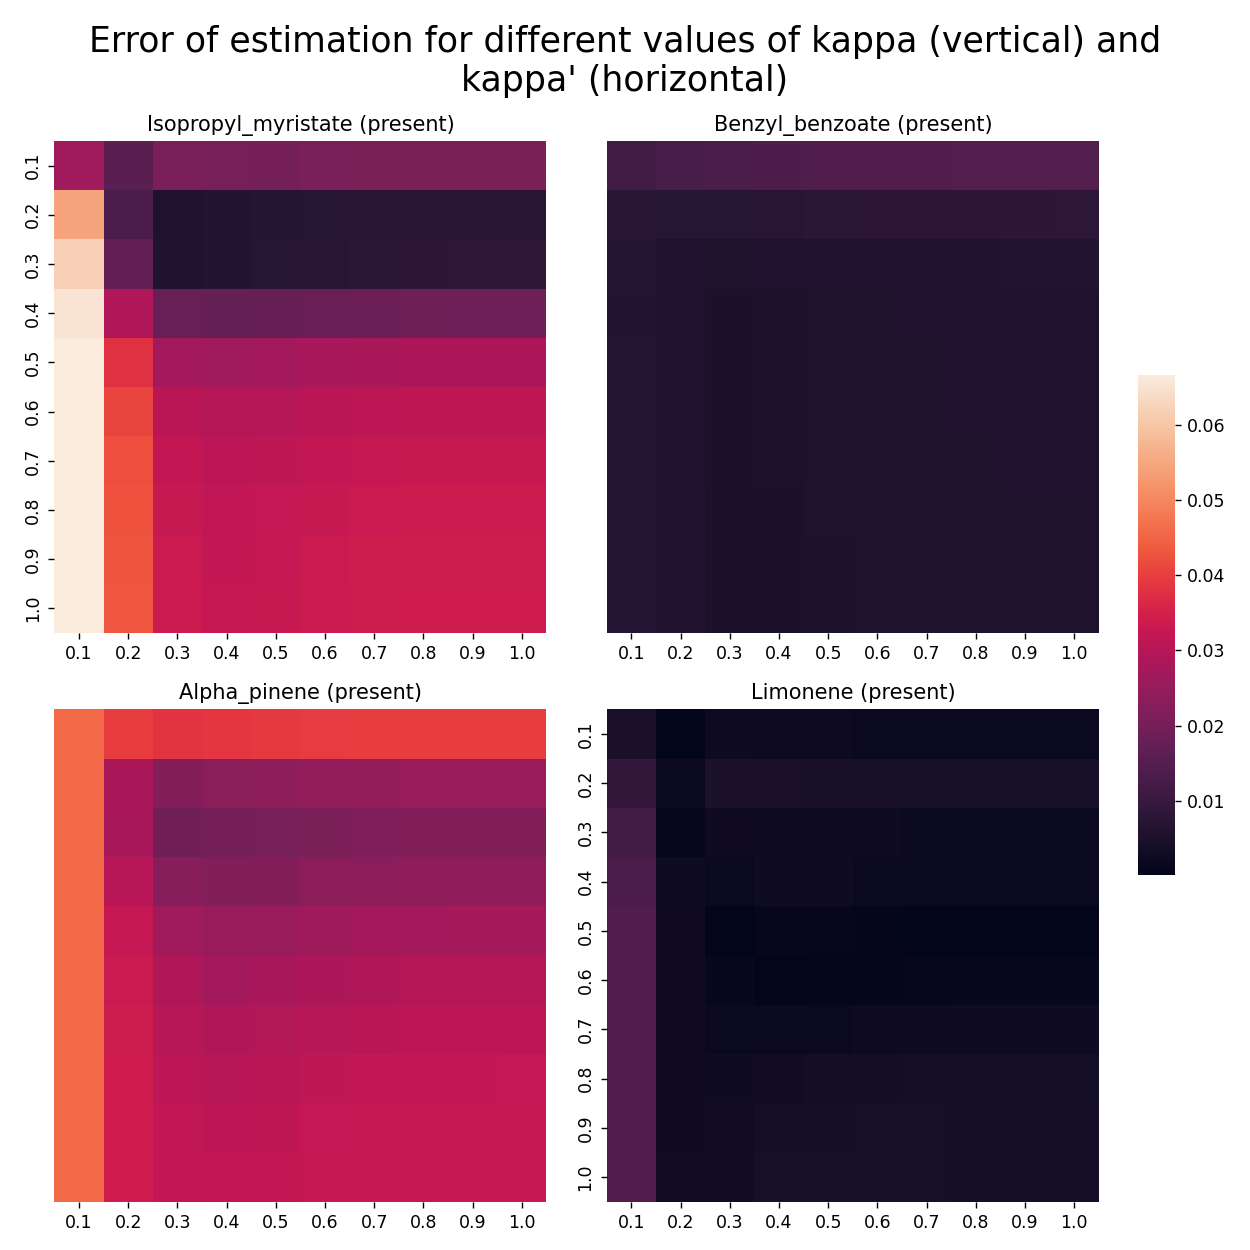

/tmp/ipykernel_49782/1522721354.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [71]:
vmin = min([df.min().min() for df in dataframes_ready_for_heatmap])
vmax = max([df.max().max() for df in dataframes_ready_for_heatmap])
labels = [round(x,1) for x in dataframes_ready_for_heatmap[0]]
#cbar_ax = fig.add_axes([0, 10, 20, 40])
names_for_plot = ['Isopropyl_myristate (present)', 'Benzyl_benzoate (present)', 'Alpha_pinene (present)',
                    'Limonene (present)']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10), gridspec_kw=dict(width_ratios=2*[1]))
plt.xlabel("kappa'", loc='left')
plt.ylabel('kappa', loc='top')


for i, ax in enumerate(axs.ravel()):
    ax.set_title(names_for_plot[i])
    if i%2==0:
        ax.set_ylabel('kappa')

cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, df in enumerate(dataframes_ready_for_heatmap):

    if i%3==0:
        sns.heatmap(dataframes_ready_for_heatmap[i].astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, ax=axs.flat[i], xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)
                #)
    else:
        sns.heatmap(dataframes_ready_for_heatmap[i].astype(float), yticklabels=False, cbar=False,
                square=True, ax=axs.flat[i], xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True),
                )

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =20)


plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

In [72]:
all_components_results = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


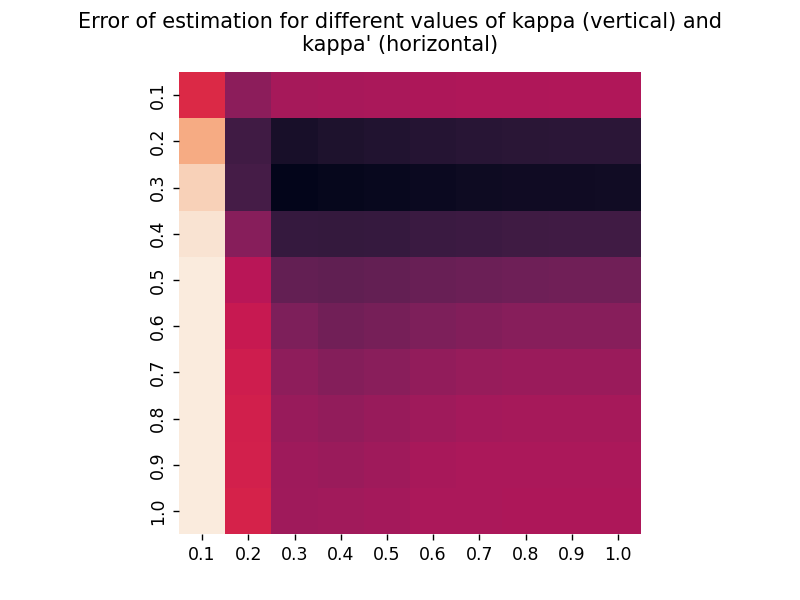

/tmp/ipykernel_49782/2263610234.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [73]:
vmin = all_components_results.min().min()
vmax = all_components_results.max().max()

sns.heatmap(all_components_results.astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

### Estimation with best parameters for simple library

In [69]:
estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3], 
                                   MTD=0.3, MTD_th=0.3, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|█████████████| 4/4 [00:00<00:00, 300.06it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(5.001421420000001, 15.998610000000001, 0), (5.001421420000001, 15.998610000000001, 1), (5.001421420000001, 15.998610000000001, 2), (5.001421420000001, 15.998610000000001, 3)]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]


Number of chunks: 1
ChunkIDs: [0, 0, 0, 0]
Chunk bounds: [(4.701421420000001, 16.29861)]


Splitting the experimental spectrum into chunks: 21684it [00:00, 2696231.71it/s]


Ion currents in chunks: [0.9999999999999976]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Deconvolving chunk 0
Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86737 rows, 21687 columns and 269910 nonzeros
Model fingerprint: 0x7843ee05
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 3e-01]
Presolve removed 23664 rows and 526 columns
Presolve time: 6.10s
Presolved: 21686 rows, 86208 columns, 268850 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 Free vars  : 525
 AA' NZ     : 1.615e+05

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:12<00:00, 12.44s/it]

Gurobi status= 2
Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.978309088304
Noise proportion in experimental spectrum: 0.021690911644999998
Total explanation: 0.999999999949
Noise proportion in combination of theoretical spectra: 0.002102705252


In [71]:
p = estimation['proportions']
p

[0.8680173052049979,
 0.038790090827999904,
 0.026519044678999935,
 0.04498264759199989]

In [72]:
vis_prop

[0.8620208303686988,
 0.04430349725220739,
 0.04577169717134345,
 0.04790397520775029]

### Finding optimal values of parameters for overrepresented library

In [81]:
lower_limit = 0.1
upper_limit = 1.1
step = 0.1

In [82]:
list_of_estimation_results = []
for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
    fixed_kappa = []
    for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
        start = time.time()
        estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3, comp4, comp5, comp6, comp7, comp8], 
                                   MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI())
        end = time.time()
        fixed_kappa.append(estimation['proportions'])
        print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
        print('It took: '+str(end-start)+' seconds.')
        print(estimation['proportions'])
    list_of_estimation_results.append(fixed_kappa)

Computing chunks: 100%|███████████████████████| 9/9 [00:00<00:00, 292625.86it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2520907.14it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86742 rows, 21687 columns and 369299 nonzeros
Model fingerprint: 0x277805ad
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e-01]
Presolve removed 23688 rows and 526 columns
Presolve time: 10.88s
Presolved: 21686 rows, 86213 columns, 368235 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 525
 AA' NZ     : 2.609e+05
 Factor NZ  : 5.941e+05 (roughly 50 MB of memory)
 Factor Ops : 1.769e+07 (less than 1 second per iteration)


Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.66s/it]


Gurobi status= 2
Estimation for 0.1 and 0.1 done
It took: 21.743582010269165 seconds.
[0.8865711618229978, 0.032919602674999916, 0.0, 0.041818022354999894, 0.0, 0.0, 0.006505880729999984, 0.0, 0.00011839611499999971]


Computing chunks: 100%|███████████████████████| 9/9 [00:00<00:00, 243540.23it/s]
Splitting the experimental spectrum into chunks: 21684it [00:00, 2934700.01it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86742 rows, 21687 columns and 369299 nonzeros
Model fingerprint: 0xcbc685ab
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 2e-01]
Presolve removed 23688 rows and 526 columns
Presolve time: 11.11s
Presolved: 21686 rows, 86213 columns, 368235 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 525
 AA' NZ     : 2.609e+05
 Factor NZ  : 5.941e+05 (roughly 50 MB of memory)
 Factor Ops : 1.769e+07 (less than 1 second per iteration)


Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.52s/it]


Gurobi status= 2
Estimation for 0.1 and 0.2 done
It took: 18.596558332443237 seconds.
[0.8431274896329979, 0.03128326929599992, 0.006212354810999985, 0.047026061817999884, 0.0, 0.0, 0.0050736032749999875, 0.0, 0.0009327404529999977]


Initial filtering of formulas:  67%|████████▋    | 6/9 [00:00<00:00, 282.65it/s]


KeyboardInterrupt: 

In [87]:
list_of_dataframes_with_results = []
for component_number in range(len([comp0, comp1, comp2, comp3, comp4, comp5, comp6, comp7, comp8])):
    results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
                                   index=np.arange(start=lower_limit, stop=upper_limit, step=step))
    for i in range(results_for_component.shape[0]):
        for j in range(results_for_component.shape[1]):
            results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
    list_of_dataframes_with_results.append(results_for_component)

IndexError: list index out of range

In [184]:
# with open('results_absent_components.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)

In [88]:
with open('results_absent_components.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [89]:
dataframes_ready_for_heatmap = []
all_proportions = vis_prop + [0, 0, 0, 0, 0]
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - all_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

<IPython.core.display.Javascript object>


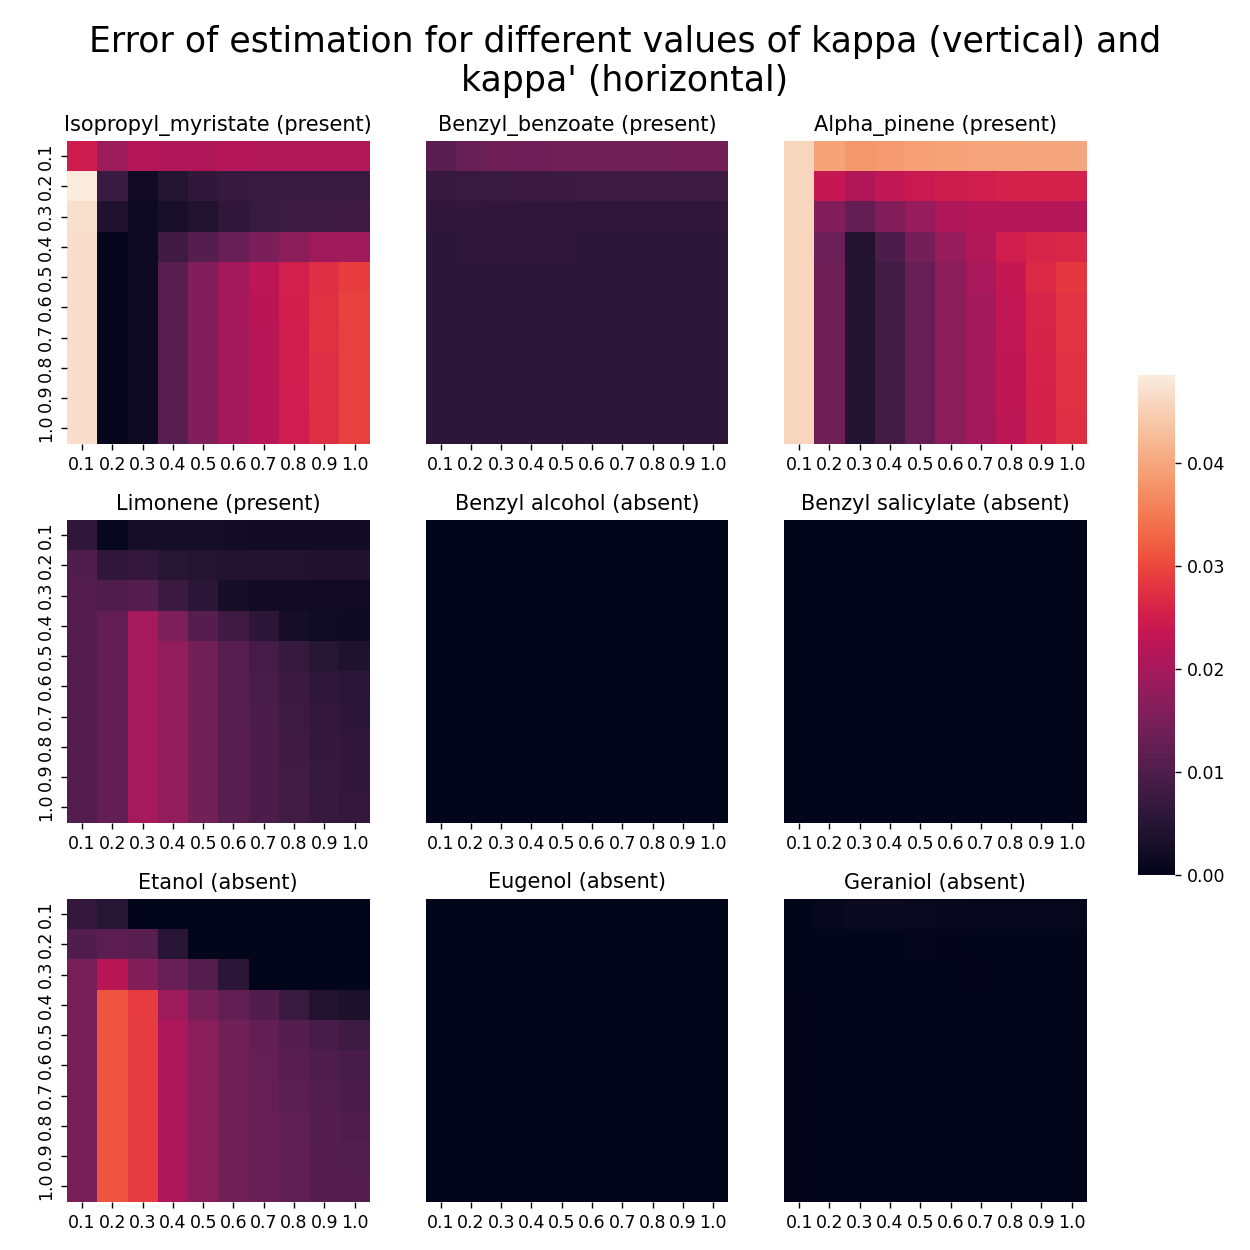

/tmp/ipykernel_49782/1376672719.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [90]:
vmin = min([df.min().min() for df in dataframes_ready_for_heatmap])
vmax = max([df.max().max() for df in dataframes_ready_for_heatmap])
labels = [round(x,1) for x in dataframes_ready_for_heatmap[0]]
#cbar_ax = fig.add_axes([0, 10, 20, 40])
names_for_plot = ['Isopropyl_myristate (present)', 'Benzyl_benzoate (present)', 'Alpha_pinene (present)',
                    'Limonene (present)', 'Benzyl alcohol (absent)', 'Benzyl salicylate (absent)', 
                    'Etanol (absent)', 'Eugenol (absent)', 'Geraniol (absent)']

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10), gridspec_kw=dict(width_ratios=3*[1]))
plt.xlabel("kappa'", loc='left')
plt.ylabel('kappa', loc='top')


for i, ax in enumerate(axs.ravel()):
    ax.set_title(names_for_plot[i])
    if i%3==0:
        ax.set_ylabel('kappa')

cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, df in enumerate(dataframes_ready_for_heatmap):

    if i%3==0:
        sns.heatmap(dataframes_ready_for_heatmap[i].astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, ax=axs.flat[i], xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)
                #)
    else:
        sns.heatmap(dataframes_ready_for_heatmap[i].astype(float), yticklabels=False, cbar=False,
                square=True, ax=axs.flat[i], xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True),
                )

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =20)


plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

In [91]:
all_components_results = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


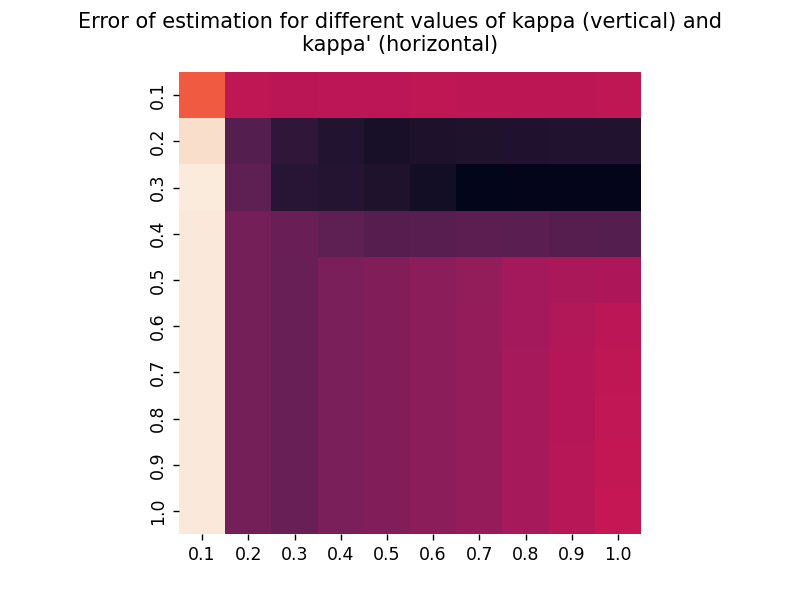

/tmp/ipykernel_49782/2263610234.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [92]:
vmin = all_components_results.min().min()
vmax = all_components_results.max().max()

sns.heatmap(all_components_results.astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

### Estimation with overrepresented library

In [93]:
estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3, comp4, comp5, comp6, comp7, comp8], 
                                   MTD=0.3, MTD_th=0.7, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|█████████████| 9/9 [00:00<00:00, 351.26it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(5.001421420000001, 15.998610000000001, 0), (5.001421420000001, 15.998610000000001, 1), (5.001421420000001, 15.998610000000001, 2), (5.001421420000001, 15.998610000000001, 3), (5.001421420000001, 15.998610000000001, 4), (5.001421420000001, 15.998610000000001, 5), (5.001421420000001, 15.998610000000001, 6), (5.001421420000001, 15.998610000000001, 7), (5.001421420000001, 15.998610000000001, 8)]


Computing chunks: 100%|███████████████████████| 9/9 [00:00<00:00, 181484.31it/s]


Number of chunks: 1
ChunkIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0]
Chunk bounds: [(4.3014214200000005, 16.698610000000002)]


Splitting the experimental spectrum into chunks: 21684it [00:00, 2385054.62it/s]


Ion currents in chunks: [0.9999999999999976]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Deconvolving chunk 0
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86742 rows, 21687 columns and 369299 nonzeros
Model fingerprint: 0x76a9e81e
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 7e-01]
Presolve removed 23688 rows and 526 columns
Presolve time: 10.95s
Presolved: 21686 rows, 86213 columns, 368235 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 525
 AA' NZ     : 2.609e+05
 Factor NZ  : 5.941e+05 (roughly 50 MB of memory)
 Factor Ops : 1.769e+07 (less than 1 s

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.68s/it]

Gurobi status= 2
Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.9780175693919999
Noise proportion in experimental spectrum: 0.021982430625999982
Total explanation: 1.0000000000179998
Noise proportion in combination of theoretical spectra: 0.000487308827


In [97]:
p = estimation['proportions']
p

[0.8694209891819978,
 0.03826904106899991,
 0.02431417830999994,
 0.04572513986299989,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0002882209679999993]

In [95]:
vis_prop

[0.8620208303686988,
 0.04430349725220739,
 0.04577169717134345,
 0.04790397520775029]

In [98]:
protons = [34, 12, 16, 16, 8, 12, 5, 11, 17, 18]
proportions_rescaled = [p/prot for p, prot in zip(p, protons)]
proportions_rescaled = [p/sum(proportions_rescaled) for p in proportions_rescaled]
proportions_rescaled

[0.7712693093708943,
 0.09618806330652492,
 0.04583470719147931,
 0.08619655454480557,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0005113655862960455]

In [100]:
real_proportions

[0.7264578344443725,
 0.10578603326645526,
 0.081968804608116,
 0.08578732768105625]

# Real proportions:
# 0.8620, 0.0443, 0.0458, 0.0479, 0, 0, 0, 0

# Estimated proportions
# 0.8694, 0.0383, 0.0243, 0.0457, 0, 0, 0, 0, 0.0002

# Below: old code

### Visualisation of our estimation

In [174]:
p = estimation['proportions'][:4]

In [175]:
p = np.array(p).reshape(len(p),1)

In [176]:
p = p[[0, 3, 1, 2],:]

In [178]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(4)]

In [179]:
components_ints = []
for spectrum in [comp0, comp3, comp1,comp2]:
    components_ints.append(np.array(spectrum.confs)[:,1].reshape(-1,1))
    components_ppm.append(np.array(spectrum.confs)[:,0])

In [180]:
X = np.concatenate(components_ints[:4], axis=1)

In [181]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

In [183]:
names_switched = [official_names[0], official_names[3], official_names[1], official_names[2]] + official_names[4:]

In [184]:
names_switched

['Isopropyl_myristate',
 'Limonene',
 'Benzyl_benzoate',
 'Alpha_pinene',
 'Benzyl alcohol',
 'Benzyl salicylate',
 'Etanol',
 'Eugenol',
 'Geraniol',
 'Menthone']

<IPython.core.display.Javascript object>


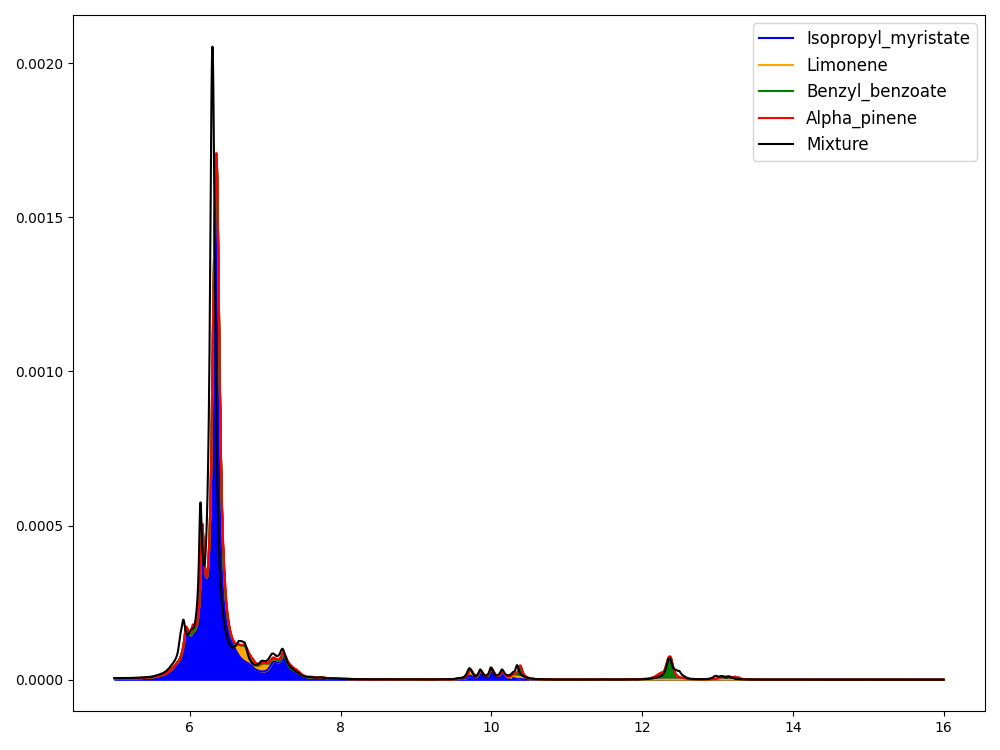

In [199]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(10, 7.5, forward=True)
# ax.set_xlim(5,8)
# ax.set_xlim(9.35,10.7)
# ax.set_ylim(-0.00001,0.0001)
# ax.set_xlim(11.9, 13.5)
# ax.set_ylim(-0.00001,0.0001)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=names_switched[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture')
ax.legend(prop={'size': 12})
plt.tight_layout()

### Visualisation of spectrum in real proportions

In [119]:
real_p = np.array(vis_prop).reshape(len(vis_prop),1)

In [122]:
real_p.shape

(4, 1)

In [123]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(4)]

In [124]:
X = np.concatenate(components_ints[:4], axis=1)

In [125]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],real_p[:(i+1),:])[:,0]

In [126]:
names_matmul

['sum_up_to_1', 'sum_up_to_2', 'sum_up_to_3', 'sum_up_to_4']

<IPython.core.display.Javascript object>


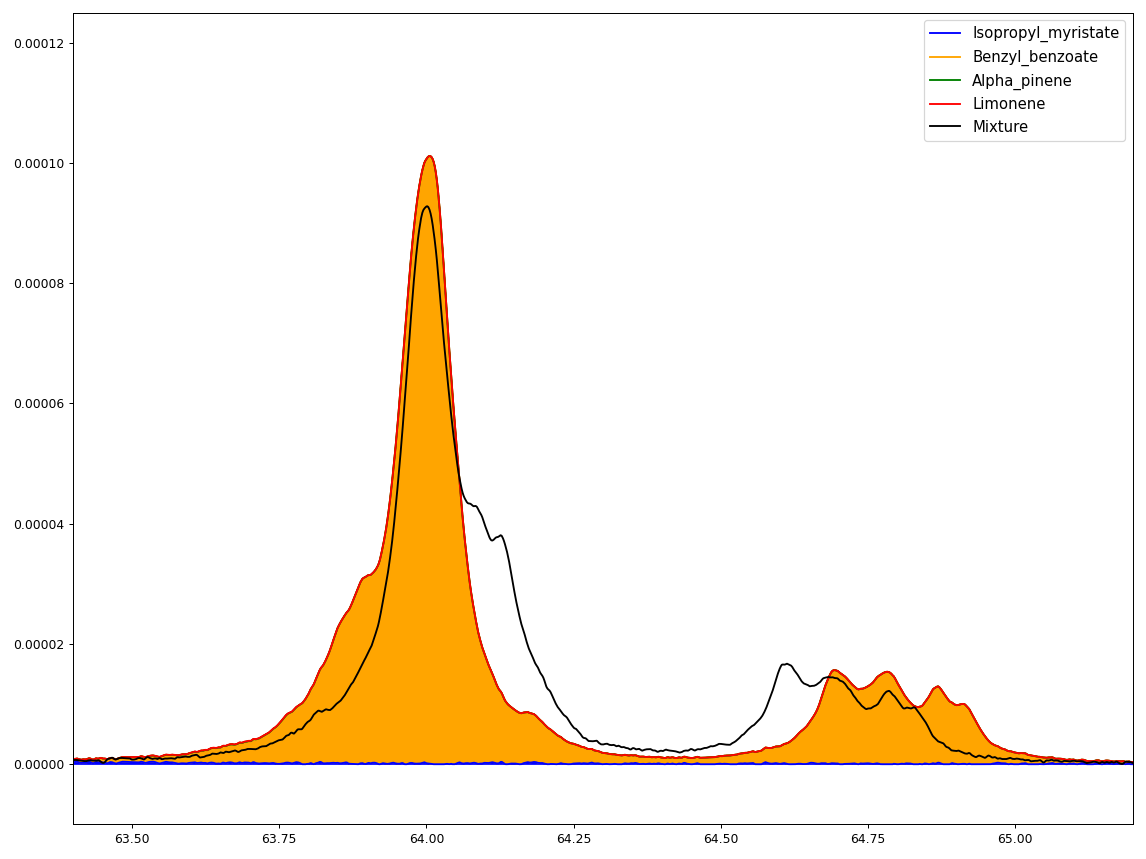

In [150]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(12.8, 9.6, forward=True)
# ax.set_xlim(57,59.5)
# ax.set_ylim(-0.0001,0.003)
# ax.set_xlim(61,62.4)
# ax.set_ylim(-0.00001,0.00008)
# ax.set_xlim(63.4,65.2)
# ax.set_ylim(-0.00001,0.000125)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor], globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture')
ax.legend(prop={'size': 12})
plt.tight_layout()

### Visualisation of our estimation

In [75]:
p = [0.8680173052049979,
 0.038790090827999904,
 0.026519044678999935,
 0.04498264759199989]

In [76]:
p = np.array(p).reshape(len(p),1)

In [77]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [78]:
components_ints = [comp_int.reshape(-1,1) for comp_int in components_ints]

In [82]:
X = np.concatenate(components_ints[:4], axis=1)

In [83]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

<IPython.core.display.Javascript object>


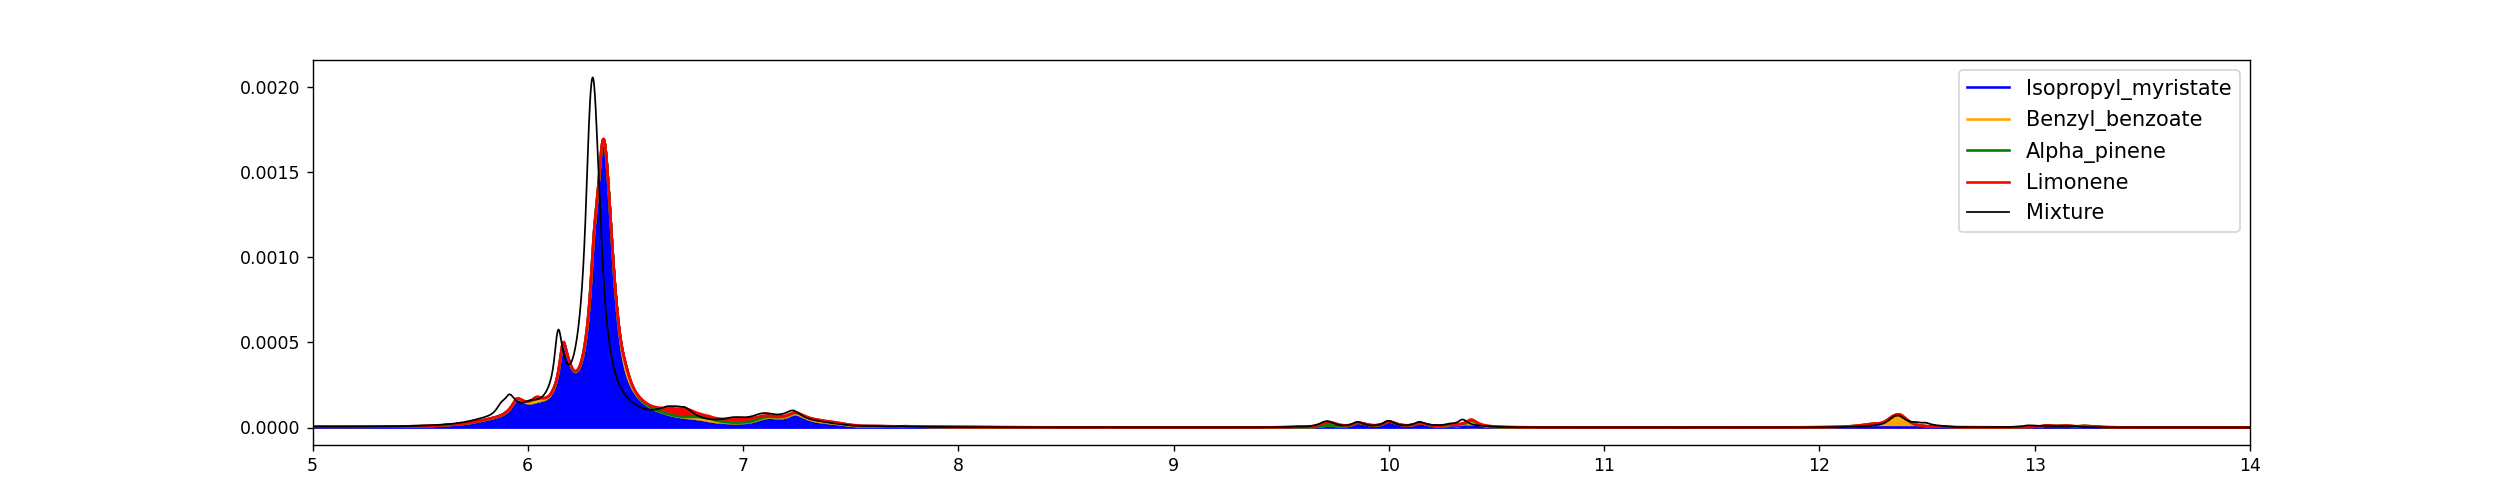

In [91]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(20, 4, forward=True)
ax.set_xlim(5,14)
# ax.set_ylim(-0.0001,0.0042)
for i, name in enumerate(names_matmul[:4]):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=1)
ax.legend(prop={'size': 12})